# Chapter 2: Temporal Evolution of Credit Risk Relationships

In [ ]:
import sys
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lightgbm as lgb
from sklearn.model_selection import train_test_split

PROJ_ROOT = Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.append(str(PROJ_ROOT))

from credit_risk_xai.config import (
    FEATURE_CACHE_PATH, ACTIVE_MODEL_VERSION, ACTIVE_FEATURES, get_display_name, FEATURE_BOUNDS
)
from credit_risk_xai.features.engineer import prepare_modeling_data
from credit_risk_xai.modeling.train import DEFAULT_PARAMS
from credit_risk_xai.modeling import compute_ale_for_feature, compute_ale_binary, compute_ece
from credit_risk_xai.modeling.evaluate import calculate_shap_importance, compute_performance_metrics
from credit_risk_xai.plotting import (
    set_thesis_style, COLORS, FIGSIZE, save_figure, despine,
)

# Initialize thesis-quality plotting style
set_thesis_style(use_tex=True)

FIGURES_DIR = PROJ_ROOT / "figures"

print(f"Model version: {ACTIVE_MODEL_VERSION} ({len(ACTIVE_FEATURES)} features)")

## 1. Define Economic Periods

We analyze 5 distinct economic periods covering 2008-2023:

In [2]:
PERIODS = {
    'pre_crisis': (2004, 2006),
    'financial_crisis': (2008, 2010),
    'sovereign_debt': (2011, 2013),
    'recovery': (2014, 2018),
    'covid': (2020, 2021),
    'post_covid': (2022, 2023)
}

## 2. Load Data and Create Period-Specific Datasets

In [3]:
df_full = pd.read_parquet(FEATURE_CACHE_PATH)
df = df_full[
    (df_full["ser_aktiv"] == 1) & 
    (df_full["sme_category"].isin(["Small", "Medium"])) & 
    (df_full["knc_kncfall"] == 1) &
    (df_full["bransch_borsbransch_konv"] != "40.0")
].copy()

In [4]:
period_data = {}

for period_name, (start, end) in PERIODS.items():
    train_mask = df['ser_year'] < start
    eval_mask = (df['ser_year'] >= start) & (df['ser_year'] <= end)
    
    df_train_period = df[train_mask].copy()
    df_eval_period = df[eval_mask].copy()
    
    if len(df_train_period) > 0 and len(df_eval_period) > 0:
        X_train, y_train = prepare_modeling_data(df_train_period)
        X_eval, y_eval = prepare_modeling_data(df_eval_period)
        
        period_data[period_name] = {
            'X_train': X_train, 'y_train': y_train,
            'X_eval': X_eval, 'y_eval': y_eval,
            'train_years': (df['ser_year'].min(), start - 1),
            'eval_years': (start, end)
        }

## 3. Train Period-Specific Models

For each period, we train a LightGBM model on historical data and evaluate on that period.

In [5]:
period_models = {}
period_predictions = {}
period_shap = {}

for period_name, data in period_data.items():
    X_train, y_train = data['X_train'], data['y_train']
    X_eval, y_eval = data['X_eval'], data['y_eval']
    
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
    
    model = lgb.LGBMClassifier(**DEFAULT_PARAMS)
    model.fit(
        X_tr, y_tr, 
        eval_set=[(X_val, y_val)], 
        eval_metric='logloss',
        categorical_feature='auto',  # Auto-detect category dtype for native categorical support
        callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=0)
    ])
    
    y_pred_proba = model.predict_proba(X_eval)[:, 1]
    metrics = compute_performance_metrics(y_eval, y_pred_proba)
    
    sample_size = min(5000, len(X_eval))
    sample_idx = np.random.choice(len(X_eval), size=sample_size, replace=False) if sample_size < len(X_eval) else np.arange(len(X_eval))
    X_eval_sample = X_eval.iloc[sample_idx]
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_eval_sample)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    
    period_models[period_name] = model
    period_predictions[period_name] = {'y_true': y_eval, 'y_pred_proba': y_pred_proba, 'metrics': metrics}
    period_shap[period_name] = {'shap_values': shap_values, 'X_eval_sample': X_eval_sample, 'feature_names': X_eval.columns.tolist()}

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to

## 4. Feature Importance Stability Analysis

### 4.1 Calculate SHAP Importance for Each Period

In [6]:
importance_by_period = {}

for period_name, shap_data in period_shap.items():
    importance = calculate_shap_importance(
        shap_data['shap_values'],
        shap_data['feature_names']
    )
    importance_by_period[period_name] = importance.set_index('feature')['importance']

importance_evolution = pd.DataFrame(importance_by_period)
importance_evolution = importance_evolution.fillna(0)

importance_evolution['mean'] = importance_evolution.mean(axis=1)
importance_evolution['std'] = importance_evolution[list(PERIODS.keys())].std(axis=1)
importance_evolution['cv'] = importance_evolution['std'] / importance_evolution['mean']
importance_evolution['cv'] = importance_evolution['cv'].replace([np.inf, -np.inf], np.nan)

importance_evolution = importance_evolution.sort_values('mean', ascending=False)
importance_evolution.head(20)

,pre_crisis,financial_crisis,sovereign_debt,recovery,covid,post_covid,mean,std,cv
feature,,,,,,,,,
dividend_yield,0.398777,0.557689,0.522305,0.561515,0.556064,0.487771,0.514020,0.063197,0.122946
ratio_cash_liquidity,0.287182,0.391526,0.407941,0.417910,0.478444,0.466623,0.408271,0.068360,0.167437
sni_group_3digit,0.273659,0.294066,0.274468,0.279052,0.260860,0.260566,0.273779,0.012501,0.045661
company_age,0.190218,0.243041,0.235323,0.224228,0.246167,0.239116,0.229682,0.020776,0.090456
ny_skuldgrd,0.202577,0.235921,0.190941,0.252158,0.218674,0.200299,0.216762,0.023505,0.108439
ny_avkegkap,0.177322,0.186137,0.187786,0.206825,0.176056,0.218986,0.192185,0.017144,0.089207
log_total_assets,0.117739,0.155483,0.168699,0.187318,0.225612,0.193889,0.174790,0.036795,0.210509
interest_coverage,0.071882,0.136512,0.121265,0.134398,0.200992,0.148103,0.135525,0.041714,0.307792
ny_kapomsh,0.031549,0.092297,0.103101,0.146912,0.185935,0.167270,0.121178,0.056876,0.469362


### 4.2 Visualize Importance Evolution Heatmap

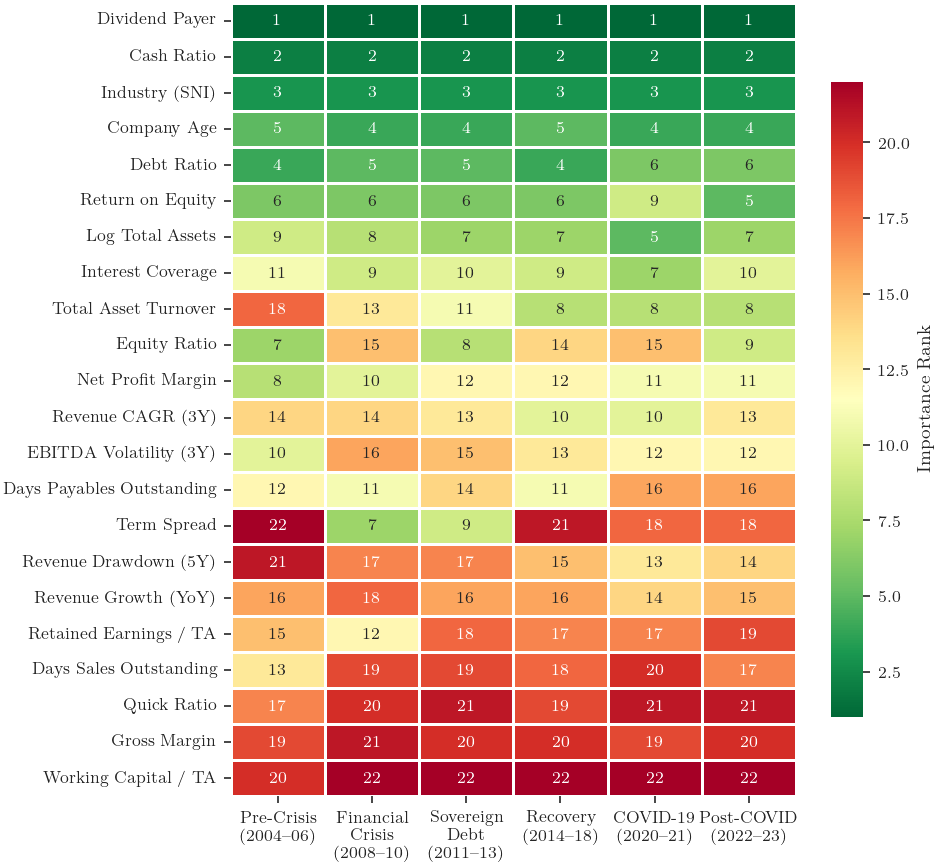

In [7]:
# Feature Importance Rank Heatmap Over Time
fig, ax = plt.subplots(figsize=FIGSIZE['full_tall'])

top_features = importance_evolution.index.tolist()

# Compute ranks for each period
rank_matrix = pd.DataFrame(index=top_features, columns=list(PERIODS.keys()))
for period_name in PERIODS.keys():
    ranks = importance_evolution[period_name].rank(ascending=False)
    rank_matrix[period_name] = ranks[top_features]

# Human-readable feature names
display_labels = [get_display_name(f) for f in top_features]

# Clean period labels
period_display_names = {
    'pre_crisis': 'Pre-Crisis\n(2004--06)',
    'financial_crisis': 'Financial\nCrisis\n(2008--10)',
    'sovereign_debt': 'Sovereign\nDebt\n(2011--13)',
    'recovery': 'Recovery\n(2014--18)',
    'covid': 'COVID-19\n(2020--21)',
    'post_covid': 'Post-COVID\n(2022--23)'
}

sns.heatmap(
    rank_matrix.astype(float),
    annot=True,
    fmt='.0f',
    annot_kws={'size': 8},
    cmap='RdYlGn_r',
    cbar_kws={'label': 'Importance Rank', 'shrink': 0.8},
    ax=ax,
    vmin=1,
    vmax=len(top_features),
    yticklabels=display_labels,
    linewidths=0.5,
    linecolor='white'
)

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([period_display_names[p] for p in PERIODS.keys()], rotation=0, ha='center')

plt.tight_layout()
save_figure(fig, FIGURES_DIR / 'temporal_importance_ranks.pdf')
plt.show()

### 4.3 Performance Comparison Across Periods

In [8]:
performance_comparison = pd.DataFrame({
    'Period': list(PERIODS.keys()),
    'AUC': [period_predictions[p]['metrics']['AUC'] for p in PERIODS.keys()],
    'PR-AUC': [period_predictions[p]['metrics']['PR-AUC'] for p in PERIODS.keys()],
    'Brier': [period_predictions[p]['metrics']['Brier Score'] for p in PERIODS.keys()],
    'ECE': [period_predictions[p]['metrics']['ECE'] for p in PERIODS.keys()],
    'Default Rate': [period_predictions[p]['y_true'].mean() for p in PERIODS.keys()]
})
performance_comparison

,Period,AUC,PR-AUC,Brier,ECE,Default Rate
0,pre_crisis,0.894681,0.150880,0.012121,0.006119,0.013237
1,financial_crisis,0.897232,0.161755,0.017167,0.005086,0.019130
2,sovereign_debt,0.903272,0.179649,0.016249,0.004564,0.018295
3,recovery,0.898120,0.161411,0.014927,0.003870,0.016513
4,covid,0.906459,0.183648,0.015117,0.004768,0.017032
5,post_covid,0.907110,0.117737,0.010018,0.005290,0.010663


## 5. ALE Plot Evolution (Threshold Shifts)

Investigate how risk relationships change across periods for key features.

In [9]:
top_features_for_ale = [
    f for f in importance_evolution.head(6).index.tolist()
    if period_data[list(PERIODS.keys())[0]]['X_eval'][f].dtype != 'category'
]

In [10]:
ale_evolution = {}

all_features = [f for f in period_data[list(PERIODS.keys())[0]]['X_eval'].columns 
                if period_data[list(PERIODS.keys())[0]]['X_eval'][f].dtype != 'category']

binary_features = [f for f in all_features if FEATURE_BOUNDS.get(f) is None]
continuous_features = [f for f in all_features if FEATURE_BOUNDS.get(f) is not None]

for i, feature in enumerate(binary_features):
    print(f"Computing ALE for binary feature: {i+1}/{len(binary_features)} {feature}")
    ale_evolution[feature] = {'is_binary': True}
    
    for period_name in PERIODS.keys():
        model = period_models[period_name]
        X_eval = period_data[period_name]['X_eval']
        
        try:
            grid, ale, bounds = compute_ale_binary(model.predict_proba, X_eval, feature)
            ale_evolution[feature][period_name] = {'grid': grid, 'ale': ale, 'bounds': bounds}
        except:
            continue

for i, feature in enumerate(continuous_features):
    print(f"Computing ALE for continuous feature: {i+1}/{len(continuous_features)} {feature}")
    ale_evolution[feature] = {}
    bounds = FEATURE_BOUNDS.get(feature)
    
    for period_name in PERIODS.keys():
        model = period_models[period_name]
        X_eval = period_data[period_name]['X_eval']
        
        try:
            grid, ale, bounds_used = compute_ale_for_feature(model.predict_proba, X_eval, feature, feature_bounds=bounds)
            ale_evolution[feature][period_name] = {'grid': grid, 'ale': ale, 'bounds': bounds_used}
        except:
            continue

Computing ALE for binary feature: 1/1 dividend_yield
Computing ALE for continuous feature: 1/20 company_age
Computing ALE for continuous feature: 2/20 ny_kapomsh
Computing ALE for continuous feature: 3/20 ny_skuldgrd
Computing ALE for continuous feature: 4/20 ny_solid
Computing ALE for continuous feature: 5/20 ny_avkegkap
Computing ALE for continuous feature: 6/20 ny_kasslikv
Computing ALE for continuous feature: 7/20 ny_nettomarg
Computing ALE for continuous feature: 8/20 ny_omsf
Computing ALE for continuous feature: 9/20 log_total_assets
Computing ALE for continuous feature: 10/20 working_capital_ta
Computing ALE for continuous feature: 11/20 retained_earnings_ta
Computing ALE for continuous feature: 12/20 interest_coverage
Computing ALE for continuous feature: 13/20 ratio_cash_liquidity
Computing ALE for continuous feature: 14/20 gross_margin
Computing ALE for continuous feature: 15/20 dso_days
Computing ALE for continuous feature: 16/20 dpo_days
Computing ALE for continuous feature

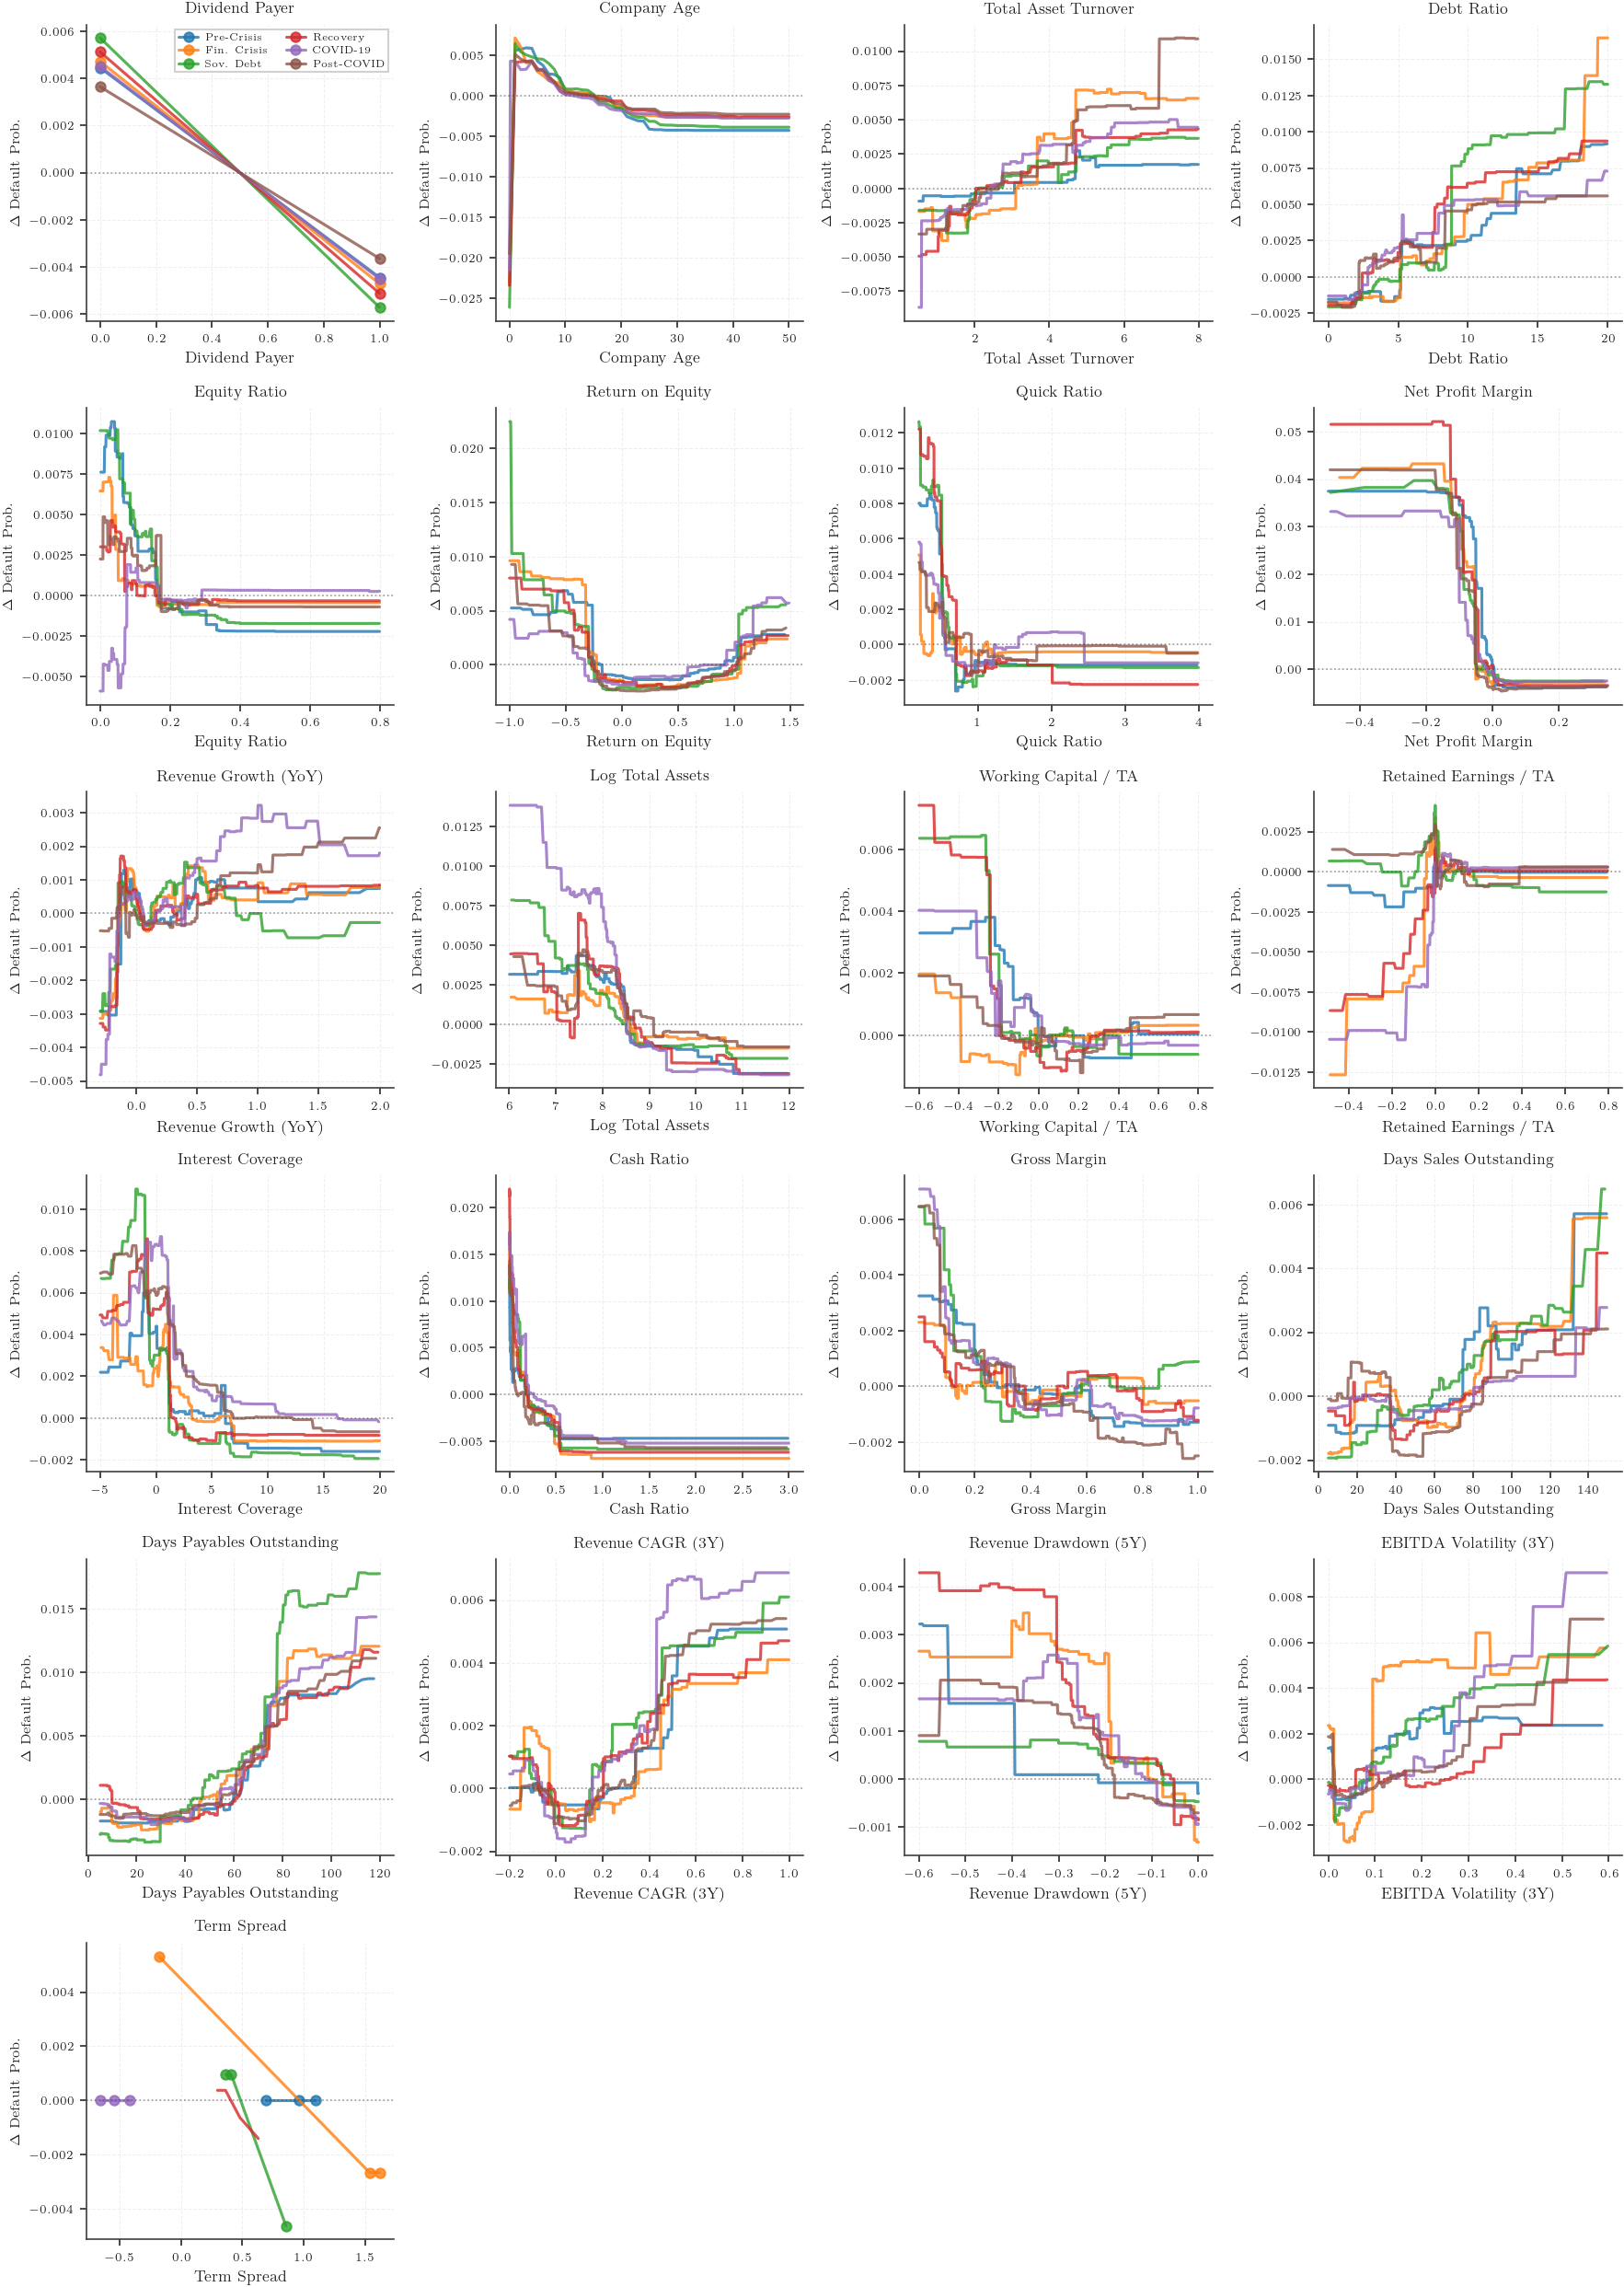

In [11]:
# ALE Evolution Grid - All Features Across Economic Periods
n_features = len(ale_evolution)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2.8 * n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

# Period colors and labels
period_colors = {
    'pre_crisis': '#1f77b4',
    'financial_crisis': '#ff7f0e',
    'sovereign_debt': '#2ca02c',
    'recovery': '#d62728',
    'covid': '#9467bd',
    'post_covid': '#8c564b'
}
period_labels = {
    'pre_crisis': 'Pre-Crisis',
    'financial_crisis': 'Fin. Crisis',
    'sovereign_debt': 'Sov. Debt',
    'recovery': 'Recovery',
    'covid': 'COVID-19',
    'post_covid': 'Post-COVID'
}

for idx, (feature, feature_data) in enumerate(ale_evolution.items()):
    ax = axes[idx]
    display_name = get_display_name(feature)
    is_binary_feature = feature_data.get('is_binary', False)
    plotted_any = False
    
    for period_name in PERIODS.keys():
        if period_name not in feature_data:
            continue
            
        ale_data = feature_data[period_name]
        
        if 'grid' not in ale_data or 'ale' not in ale_data:
            continue
            
        if len(ale_data['grid']) > 0 and len(ale_data['ale']) > 0:
            is_binary = is_binary_feature or len(ale_data['grid']) <= 3
            
            ax.plot(
                ale_data['grid'],
                ale_data['ale'],
                label=period_labels[period_name],
                linewidth=1.5,
                color=period_colors[period_name],
                marker='o' if is_binary else None,
                markersize=5,
                alpha=0.8
            )
            plotted_any = True
    
    if plotted_any:
        ax.axhline(y=0, color=COLORS['neutral'], linestyle=':', linewidth=0.8, alpha=0.5)
        ax.set_xlabel(display_name, fontsize=8)
        ax.set_ylabel(r'$\Delta$ Default Prob.', fontsize=7)
        ax.set_title(display_name, fontsize=8, fontweight='bold')
        ax.tick_params(labelsize=6)
        despine(ax)
        
        if idx == 0:
            ax.legend(fontsize=5, loc='best', ncol=2)
    else:
        ax.text(0.5, 0.5, f'{display_name}\n(No variation)', 
                ha='center', va='center', transform=ax.transAxes, fontsize=8)
        ax.set_title(display_name, fontsize=8, fontweight='bold')

for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
save_figure(fig, FIGURES_DIR / 'ale_temporal_evolution.pdf')
plt.show()

## 6. Feature Importance Evolution Over Time

Visualize how SHAP importance changes across economic periods for all features.

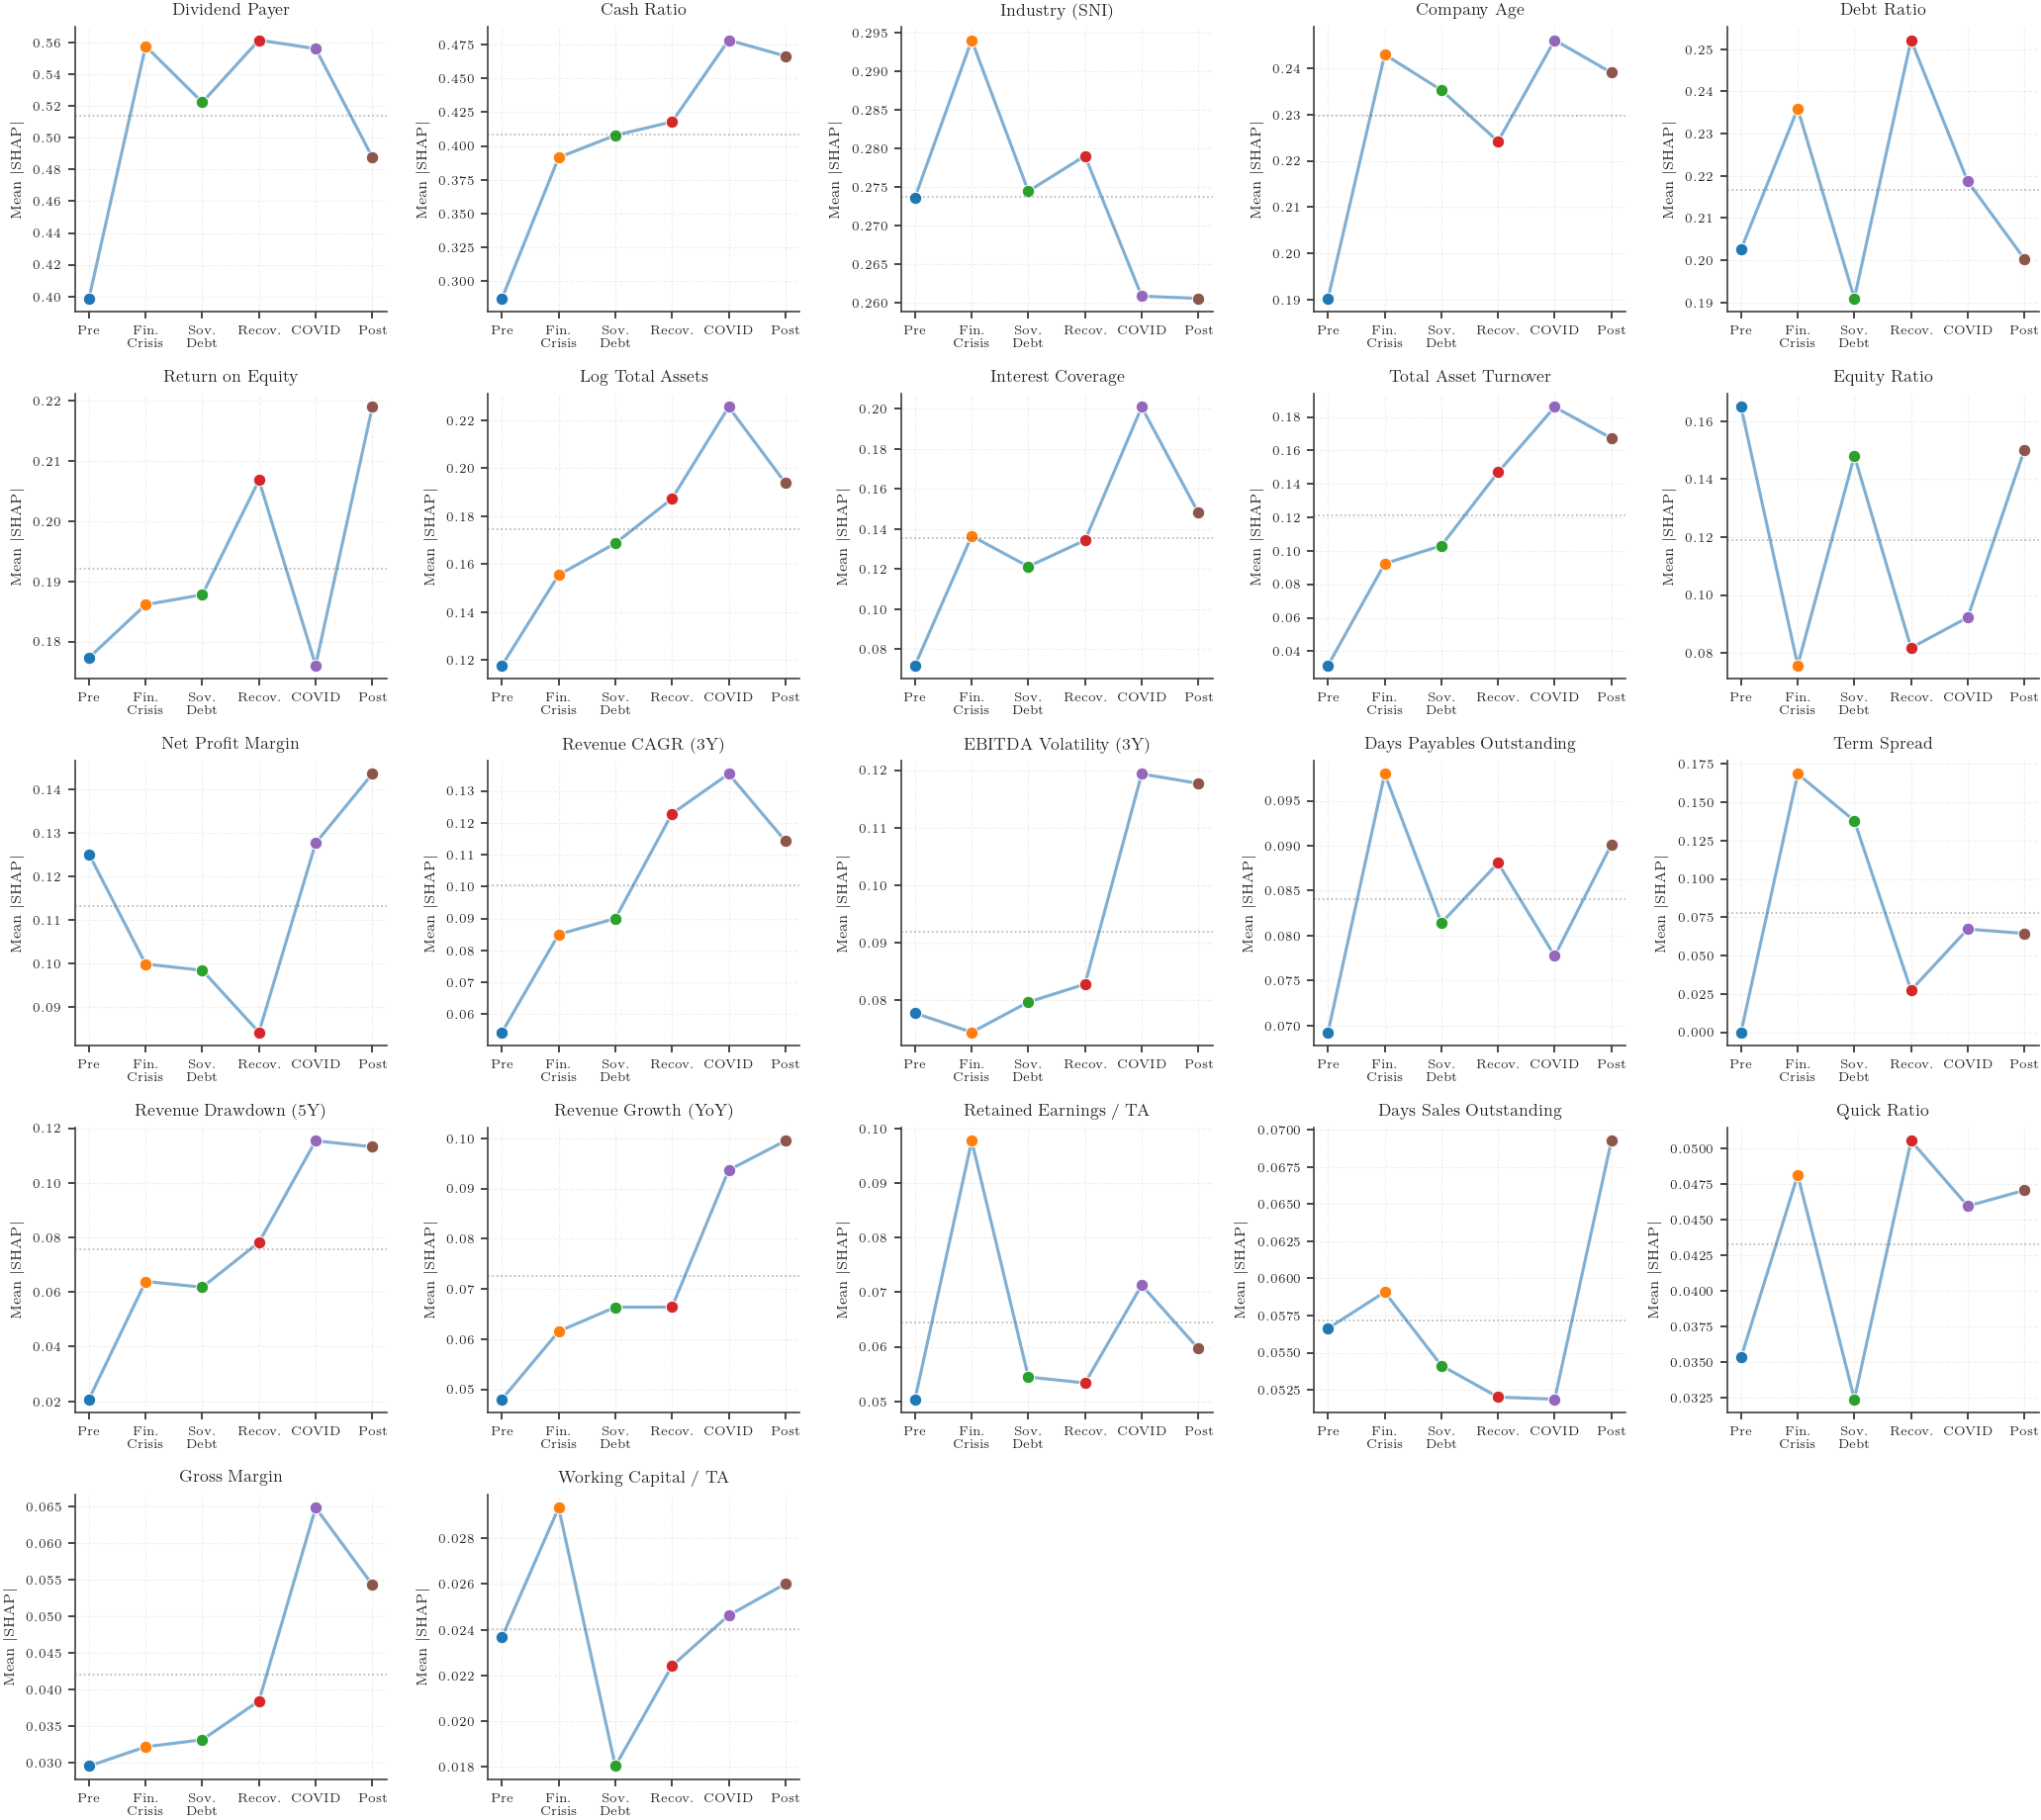

In [12]:
# Individual Feature Importance Evolution Over Time
n_features = len(importance_evolution)
n_cols = 5
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 2.5 * n_rows))
axes = axes.flatten()

period_names = list(PERIODS.keys())
x_positions = np.arange(len(period_names))

period_colors = {
    'pre_crisis': '#1f77b4',
    'financial_crisis': '#ff7f0e',
    'sovereign_debt': '#2ca02c',
    'recovery': '#d62728',
    'covid': '#9467bd',
    'post_covid': '#8c564b'
}

period_short = ['Pre', 'Fin.\nCrisis', 'Sov.\nDebt', 'Recov.', 'COVID', 'Post']

for idx, (feature, row) in enumerate(importance_evolution.iterrows()):
    ax = axes[idx]
    display_name = get_display_name(feature)
    importance_values = [row[p] for p in period_names]
    
    # Line connecting points
    ax.plot(x_positions, importance_values, 
            linewidth=1.5, color=COLORS['lgbm'], alpha=0.6)
    
    # Colored markers for each period
    for i, period in enumerate(period_names):
        ax.plot(i, importance_values[i], 'o', 
                markersize=6, color=period_colors[period], 
                markeredgecolor='white', markeredgewidth=0.5)
    
    ax.set_xticks(x_positions)
    ax.set_xticklabels(period_short, fontsize=6, rotation=0)
    ax.set_ylabel(r'Mean $|\mathrm{SHAP}|$', fontsize=7)
    ax.set_title(display_name, fontsize=8, fontweight='bold')
    ax.tick_params(labelsize=6)
    despine(ax)
    
    # Mean reference line
    mean_importance = np.mean(importance_values)
    ax.axhline(y=mean_importance, color=COLORS['neutral'], linestyle=':', linewidth=0.8, alpha=0.4)

for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## 6. Grouped Feature Importance Analysis

**Problem**: Individual feature importance is noisy due to limited samples per period. 
**Solution**: Aggregate features into economically meaningful groups to identify systematic patterns.

Based on the feature documentation (engineered_features.md), we group features into:
1. **Profitability** - Margins, returns on capital
2. **Liquidity** - Cash ratios, quick ratios
3. **Leverage** - Debt structure, solvency
4. **Growth/Momentum** - YoY changes, CAGRs
5. **Working Capital** - DSO, DPO, inventory efficiency
6. **Scale** - Size proxies (log-transformed nominals)
7. **Behavioral** - Dividend policy, credit history
8. **Macro** - Term spread (economic conditions)

In [13]:
FEATURE_GROUPS = {
    'Profitability': [
        'ny_avkegkap', 'ny_nettomarg', 'ny_foradlvpanst', 'ny_omspanst',
        'rr07_rorresul_yoy_pct', 'profit_cagr_3y',
    ],
    'Liquidity': [
        'ratio_cash_liquidity', 'ny_kasslikv', 'log_br07b_kabasu',
        'ratio_cash_interest_cov', 'ratio_cash_liquidity_yoy_pct', 'ratio_cash_liquidity_yoy_abs',
    ],
    'Leverage': [
        'ny_skuldgrd', 'ny_solid', 'ny_rs', 'ratio_short_term_debt_share',
        'ratio_retained_earnings_equity', 'ny_solid_yoy_diff',
    ],
    'Growth_Momentum': [
        'ny_omsf', 'rr01_ntoms_yoy_abs', 'revenue_cagr_3y',
        'revenue_drawdown_5y', 'ny_anstf', 'current_ratio_yoy_pct',
    ],
    'Working_Capital': [
        'dso_days', 'dpo_days', 'dso_days_yoy_diff', 'dpo_days_yoy_diff',
        'inventory_days_yoy_diff', 'dpo_days_trend_3y',
    ],
    'Scale_Industry': [
        'log_br10_eksu', 'log_bslov_antanst', 'log_rr15_resar',
        'sni_group_3digit', 'company_age', 'ny_kapomsh',
    ],
    'Behavioral': [
        'dividend_yield', 'any_event_last_5y', 'ratio_depreciation_cost',
    ],
    'Macro': [
        'term_spread',
    ],
}

all_grouped_features = [f for group in FEATURE_GROUPS.values() for f in group]
all_model_features = importance_evolution.index.tolist()

In [14]:
grouped_importance = pd.DataFrame(index=FEATURE_GROUPS.keys(), columns=list(PERIODS.keys()))

for period_name in PERIODS.keys():
    for group_name, features in FEATURE_GROUPS.items():
        valid_features = [f for f in features if f in importance_evolution.index]
        if valid_features:
            group_total = importance_evolution.loc[valid_features, period_name].sum()
            grouped_importance.loc[group_name, period_name] = group_total
        else:
            grouped_importance.loc[group_name, period_name] = 0

grouped_importance = grouped_importance.astype(float)

grouped_importance['mean'] = grouped_importance[list(PERIODS.keys())].mean(axis=1)
grouped_importance['std'] = grouped_importance[list(PERIODS.keys())].std(axis=1)
grouped_importance['cv'] = grouped_importance['std'] / grouped_importance['mean']

grouped_importance = grouped_importance.sort_values('mean', ascending=False)
grouped_importance.round(3)

,pre_crisis,financial_crisis,sovereign_debt,recovery,covid,post_covid,mean,std,cv
Scale_Industry,0.495,0.629,0.613,0.650,0.693,0.667,0.625,0.069,0.111
Behavioral,0.399,0.558,0.522,0.562,0.556,0.488,0.514,0.063,0.123
Liquidity,0.322,0.440,0.440,0.468,0.524,0.514,0.451,0.073,0.161
Leverage,0.368,0.312,0.339,0.334,0.311,0.350,0.336,0.022,0.066
Profitability,0.302,0.286,0.286,0.291,0.304,0.363,0.305,0.029,0.095
Growth_Momentum,0.123,0.210,0.218,0.267,0.344,0.327,0.248,0.082,0.331
Working_Capital,0.126,0.157,0.136,0.140,0.130,0.159,0.141,0.014,0.099
Macro,0.000,0.168,0.138,0.027,0.067,0.064,0.078,0.064,0.830


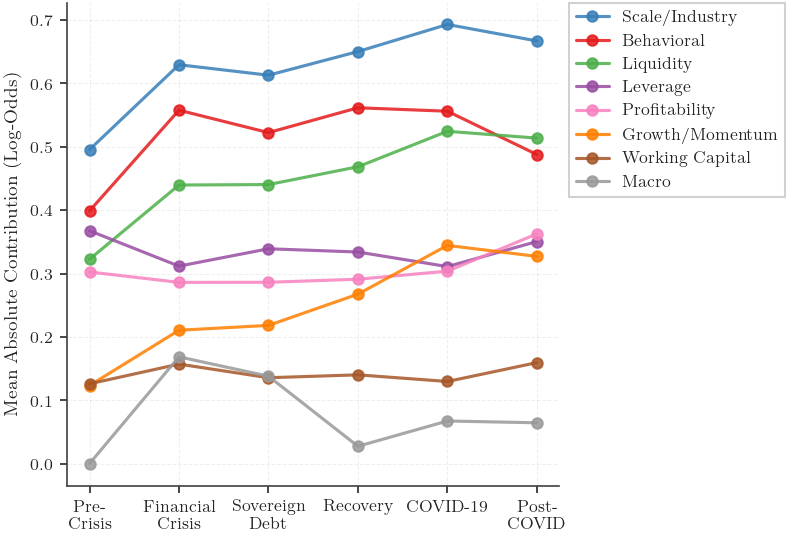

In [19]:
# Feature Group Importance Evolution - Standalone Figure
fig, ax = plt.subplots(figsize=FIGSIZE['standalone'])

group_colors = {
    'Behavioral': '#e41a1c',
    'Scale_Industry': '#377eb8',
    'Liquidity': '#4daf4a',
    'Leverage': '#984ea3',
    'Growth_Momentum': '#ff7f00',
    'Profitability': '#f781bf',
    'Working_Capital': '#a65628',
    'Macro': '#999999',
}

# Cleaner group names for legend
group_display_names = {
    'Scale_Industry': 'Scale/Industry',
    'Growth_Momentum': 'Growth/Momentum',
    'Working_Capital': 'Working Capital',
}

period_order = list(PERIODS.keys())
x_positions = np.arange(len(period_order))

# Period display labels
period_display = {
    'pre_crisis': 'Pre-\nCrisis',
    'financial_crisis': 'Financial\nCrisis',
    'sovereign_debt': 'Sovereign\nDebt',
    'recovery': 'Recovery',
    'covid': 'COVID-19',
    'post_covid': 'Post-\nCOVID'
}

for group_name in grouped_importance.index:
    values = grouped_importance.loc[group_name, period_order].values
    display_name = group_display_names.get(group_name, group_name)
    ax.plot(x_positions, values, 
            marker='o', linewidth=1.5, markersize=5,
            label=display_name, color=group_colors.get(group_name, 'gray'),
            alpha=0.85)

ax.set_xticks(x_positions)
ax.set_xticklabels([period_display[p] for p in period_order])
ax.set_ylabel(r'Mean Absolute Contribution (Log-Odds)')
ax.set_xlabel('')
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0, frameon=True)
despine(ax)

plt.tight_layout()
save_figure(fig, FIGURES_DIR / 'temporal_group_importance.pdf')
plt.show()

### 6.1 Detailed Temporal Pattern Analysis

Let's examine specific patterns more closely to understand the economic intuition behind the importance shifts.

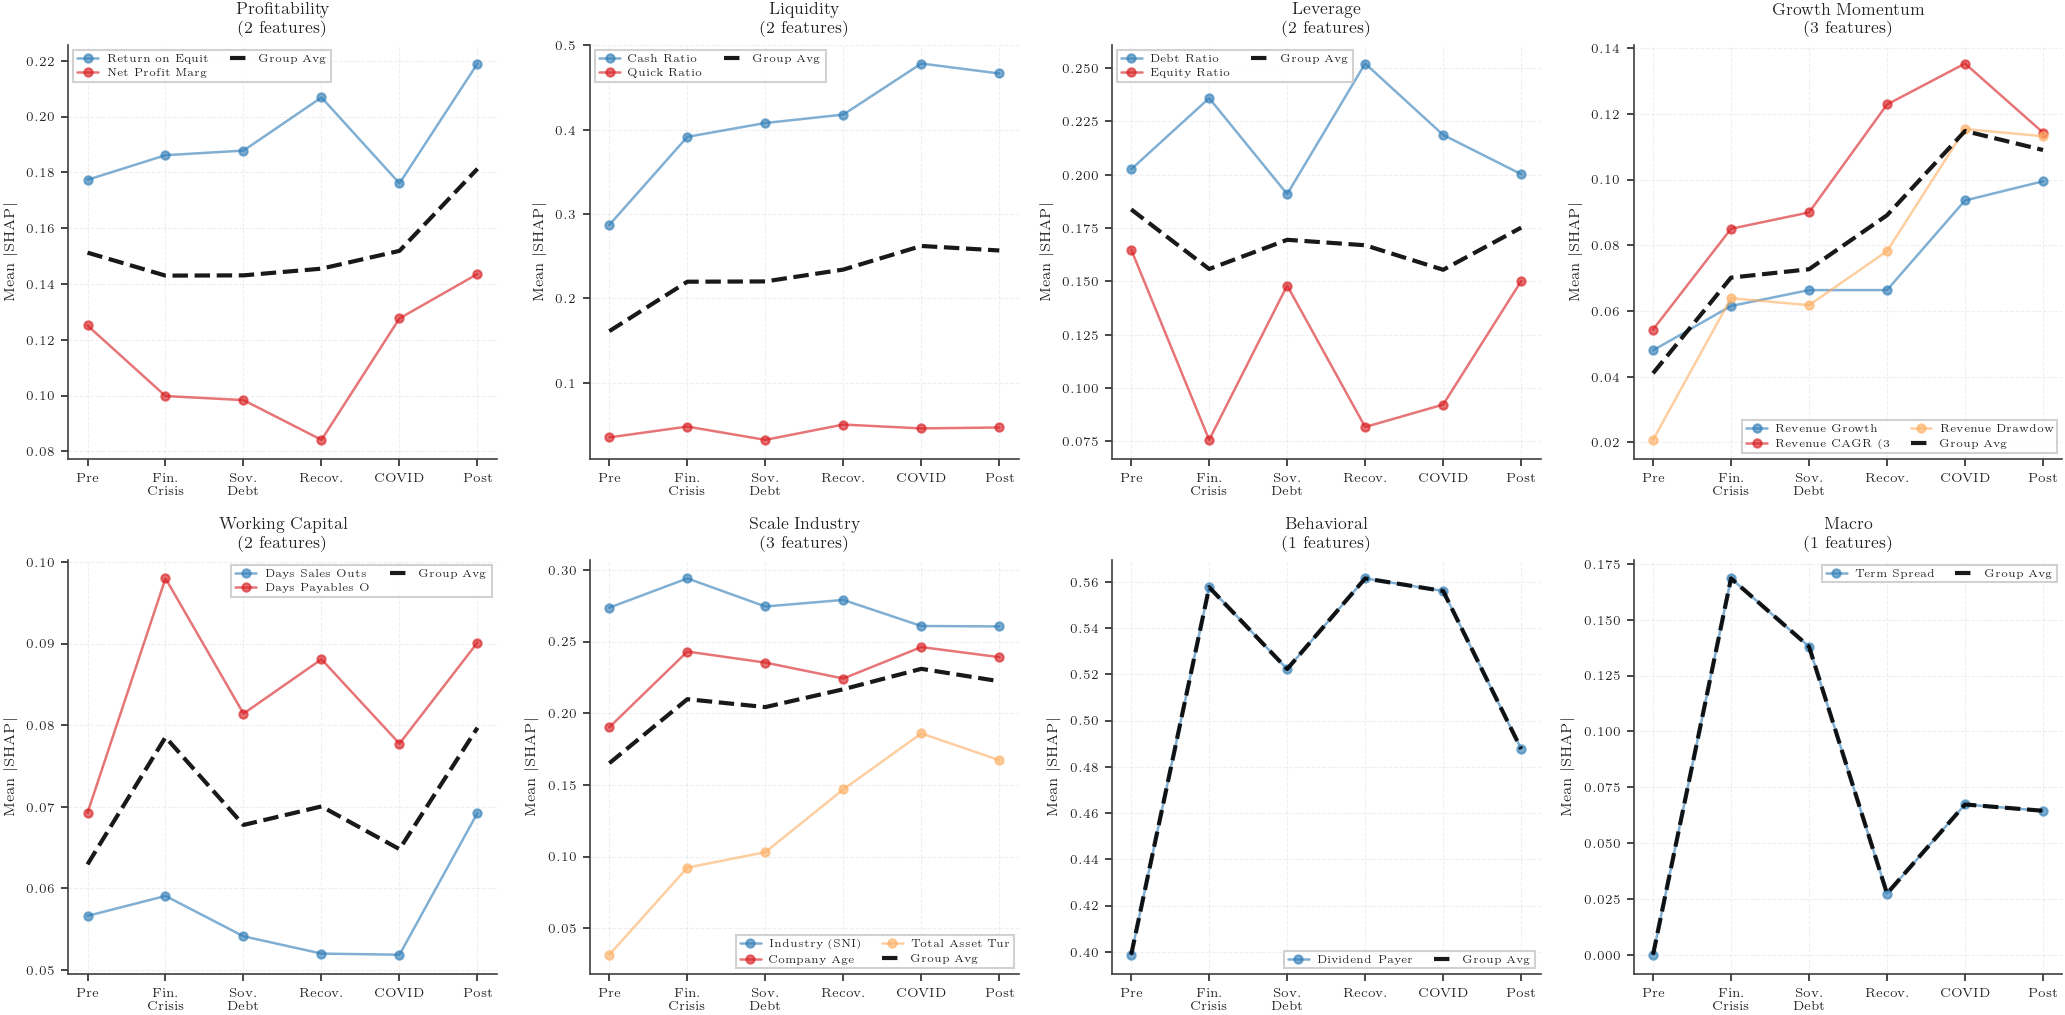

In [16]:
# Detailed Temporal Pattern Analysis by Feature Group
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

period_labels = {
    'pre_crisis': 'Pre',
    'financial_crisis': 'Fin.\nCrisis',
    'sovereign_debt': 'Sov.\nDebt',
    'recovery': 'Recov.',
    'covid': 'COVID',
    'post_covid': 'Post'
}

for idx, (group_name, features) in enumerate(FEATURE_GROUPS.items()):
    if idx >= len(axes):
        break
    
    ax = axes[idx]
    valid_features = [f for f in features if f in importance_evolution.index]
    
    if not valid_features:
        ax.text(0.5, 0.5, f'{group_name}\n(No features)', ha='center', va='center')
        continue
    
    for feature in valid_features:
        display_name = get_display_name(feature)
        values = importance_evolution.loc[feature, list(PERIODS.keys())].values
        ax.plot(range(len(PERIODS)), values, 
                marker='o', linewidth=1.2, markersize=4,
                label=display_name[:15], alpha=0.6)
    
    # Group average (bold)
    group_avg = importance_evolution.loc[valid_features, list(PERIODS.keys())].mean(axis=0)
    ax.plot(range(len(PERIODS)), group_avg.values, 
            linewidth=2, color='black', linestyle='--',
            label='Group Avg', alpha=0.9)
    
    ax.set_xticks(range(len(PERIODS)))
    ax.set_xticklabels([period_labels[p] for p in PERIODS.keys()], fontsize=6)
    ax.set_ylabel(r'Mean $|\mathrm{SHAP}|$', fontsize=7)
    
    # Clean group name for title
    clean_name = group_name.replace('_', ' ')
    ax.set_title(f'{clean_name}\n({len(valid_features)} features)', fontsize=8, fontweight='bold')
    ax.tick_params(labelsize=6)
    ax.legend(fontsize=5, loc='best', ncol=2)
    despine(ax)

for idx in range(len(FEATURE_GROUPS), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

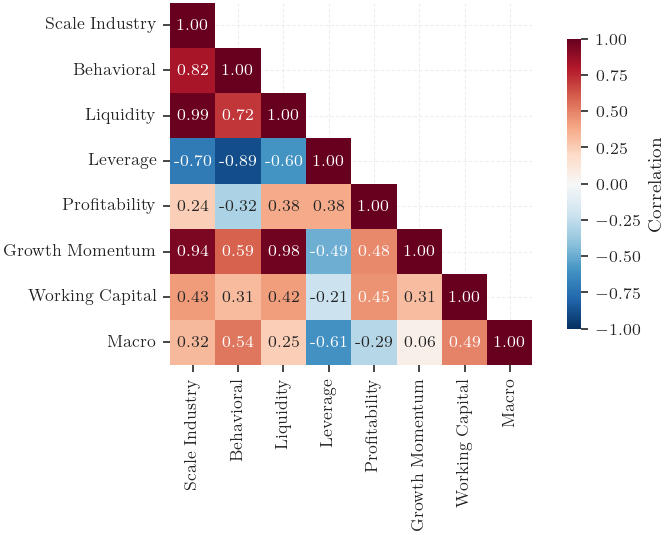

In [17]:
# Temporal Correlation Between Feature Groups
group_temporal_corr = grouped_importance[list(PERIODS.keys())].T.corr()

fig, ax = plt.subplots(figsize=FIGSIZE['standalone'])

# Lower triangle mask
mask = np.triu(np.ones_like(group_temporal_corr, dtype=bool), k=1)

# Clean group names for display
clean_names = [n.replace('_', ' ') for n in group_temporal_corr.index]

sns.heatmap(group_temporal_corr, annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, ax=ax,
            mask=mask, square=True,
            vmin=-1, vmax=1,
            annot_kws={'size': 8},
            xticklabels=clean_names,
            yticklabels=clean_names,
            cbar_kws={'label': 'Correlation', 'shrink': 0.8})

ax.tick_params(labelsize=8)

plt.tight_layout()
save_figure(fig, FIGURES_DIR / 'temporal_group_correlation.pdf')
plt.show()

## 7. Cache Results for Future Analysis

In [18]:
results_dir = PROJ_ROOT / "results" / "xai_temporal"
results_dir.mkdir(parents=True, exist_ok=True)

importance_evolution.to_csv(results_dir / "importance_evolution.csv")
grouped_importance.to_csv(results_dir / "grouped_importance_evolution.csv")
performance_comparison.to_csv(results_dir / "performance_by_period.csv", index=False)

cache_file = results_dir / "temporal_cache.pkl"
with open(cache_file, 'wb') as f:
    pickle.dump({
        'period_models': period_models,
        'period_predictions': period_predictions,
        'period_shap': period_shap,
        'ale_evolution': ale_evolution,
        'importance_evolution': importance_evolution,
        'grouped_importance': grouped_importance,
    }, f)